Clone the code repo, and download data file and models.

In [1]:
!git clone https://github.com/SarodYatawatta/LSHM
#change working directory
%cd LSHM/src

Cloning into 'LSHM'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 193 (delta 4), reused 17 (delta 4), pack-reused 172
Receiving objects: 100% (193/193), 111.75 MiB | 1.02 MiB/s, done.
Resolving deltas: 100% (100/100), done.
/tmp/LSHM/src


Please download the following files, and copy them to ```LSHM/src``` (our working directory)

[data h5](https://drive.google.com/file/d/1t-nckTdUGtJ2GeOKIT5Qb1KG56JJjg_J/view?usp=sharing)
file name ```L785751.MS_extract.h5``` (4 GB size, so be patient).

[models](https://drive.google.com/file/d/1TeGVfxx7jAgOiXo-KXKtV87Qqdb2Rdn8/view?usp=sharing) Please unzip ```models.zip```, you will get ```net.model```, ```fnet.model``` and ```khm.model``` files.


Import python modules, required are : *torch*, *numpy*, *h5py*, *torchvision*, *sklearn*, *matplotlib*, *seaborn*

In [2]:
import torch
import torchvision
import numpy as np
import h5py

import torch.fft

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

Instantiate and load pre-trained models ```net.model```, ```fnet.model```, ```khm.model``` 

In [3]:
# Do not change the following, they should match the values used during training
L=256 # latent dimension
Lf=64 # latent dimension
Kc=10 # clusters
Khp=4 # order of K harmonic mean 1/|| ||^p norm

patch_size=128

# import LOFAR models
# If you have a GPU, first edit lofar_models.py 
# and set use_cuda=False to force to use the CPU before import
from lofar_models import *

num_in_channels=4 # real,imag XX,YY
# for 128x128 patches
net=AutoEncoderCNN2(latent_dim=L,channels=num_in_channels)
# fft: real,imag, so increase number of channels
fnet=AutoEncoderCNN2(latent_dim=Lf,channels=2*num_in_channels)
mod=Kmeans(latent_dim=(L+Lf),p=Khp)

checkpoint=torch.load('./net.model',map_location=torch.device('cpu'))
net.load_state_dict(checkpoint['model_state_dict'])
checkpoint=torch.load('./fnet.model',map_location=torch.device('cpu'))
fnet.load_state_dict(checkpoint['model_state_dict'])
checkpoint=torch.load('./khm.model',map_location=torch.device('cpu'))
mod.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

We use the downloaded file as input data, so set ```file_name``` to this file.

In [4]:
file_name='L785751.MS_extract.h5'
file_sap='1' # valid in the file

# get nbase,nfreq,ntime,npol,ncomplex
nbase,nfreq,ntime,npol,ncomplex=get_metadata(file_name,file_sap)
X=np.zeros([Kc,nbase],dtype=np.float64)
clusid=np.zeros(nbase,dtype=np.float64)

This dataset has about 3000 baselines, we go through each of them, and find the distance of each from the k-harmonic mean centroids. We store these distances in ```X```. This might take a few minutes to run.

In [5]:
for nb in range(nbase):
    patchx,patchy,x=get_data_for_baseline(file_name,file_sap,baseline_id=nb,patch_size=128,num_channels=num_in_channels)
    # get latent variable
    xhat,mu=net(x)
    # perform 2D fft
    fftx=torch.fft.fftn(x-xhat,dim=(2,3),norm='ortho')
    # fftshift
    freal,fimag=torch_fftshift(fftx.real,fftx.imag)
    y=torch.cat((freal,fimag),1)
    # clamp high values data
    y.clamp_(min=-10,max=10)
    yhat,ymu=fnet(y)
    Mu=torch.cat((mu,ymu),1)
    kdist=mod(Mu)
    (nbatch,_)=Mu.shape
    dist=torch.zeros(Kc)
    for ck in range(Kc):
        for cn in range(nbatch):
            dist[ck]=dist[ck]+(torch.norm(Mu[cn,:]-mod.M[ck,:],2))
    dist=dist/nbatch
    X[:,nb]=dist.detach().numpy()
    (values,indices)=torch.min(dist.view(Kc,1),0)
    clusid[nb]=indices[0]

Feed the distance array ```X``` to final dimention reduction and thereafter to hard clustering. First we pass it to *t-SNE* and next to agglomerative clustering.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2850 samples in 0.024s...
[t-SNE] Computed neighbors for 2850 samples in 0.096s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2850
[t-SNE] Computed conditional probabilities for sample 2000 / 2850
[t-SNE] Computed conditional probabilities for sample 2850 / 2850
[t-SNE] Mean sigma: 0.003288
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.118370
[t-SNE] KL divergence after 1000 iterations: 0.871198


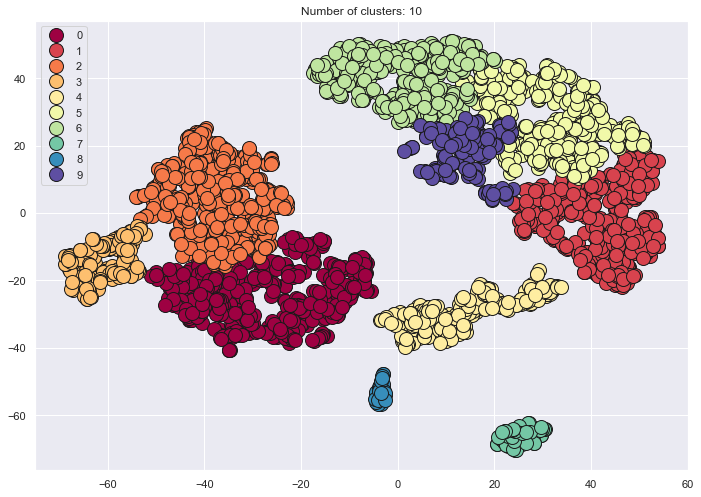

In [6]:
### tSNE
tsne=TSNE(verbose=True)
X_emb=tsne.fit_transform(X.transpose())
uniq=np.unique(clusid)
snsplot=sns.scatterplot(x=X_emb[:,0], y=X_emb[:,1], hue=clusid, legend='full',
  palette = sns.color_palette("bright", n_colors=len(uniq)))
snsplot.figure.savefig('scatter.png')

### final clustering
scaler=StandardScaler()
X_embsc=scaler.fit_transform(X_emb)
db=AgglomerativeClustering(linkage='average',n_clusters=10).fit(X_embsc)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

unique_labels = set(db.labels_)
colors = [plt.cm.Spectral(each)
  for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    class_member_mask = (db.labels_ == k)
    xy = X_emb[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
        markeredgecolor='k', markersize=14)

plt.legend(labels=np.unique(db.labels_))
plt.title('Number of clusters: %d' % n_clusters_)
plt.savefig('clusters.png')

Finally, use the labels of hard clustering to group the ~3000 spectrograms together.

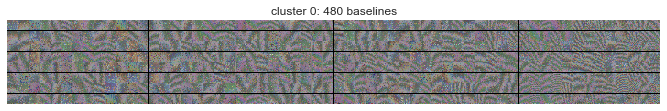

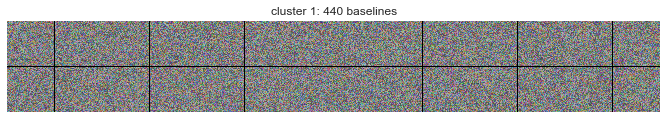

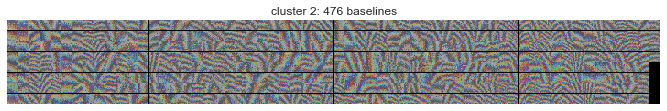

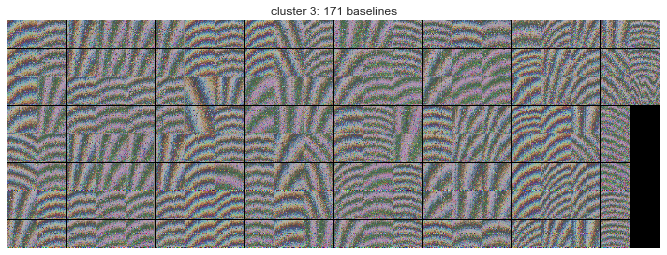

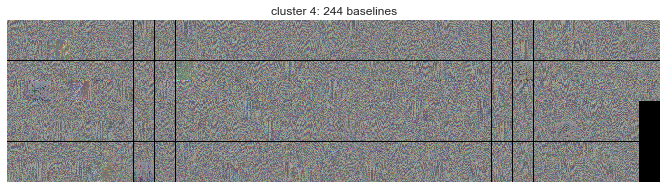

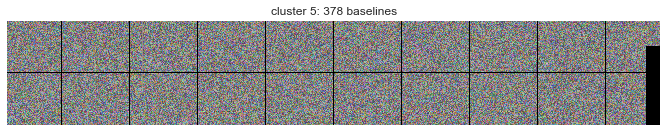

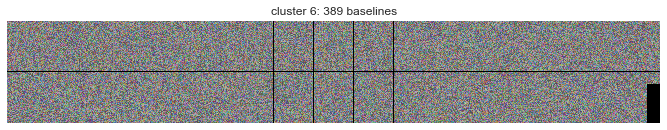

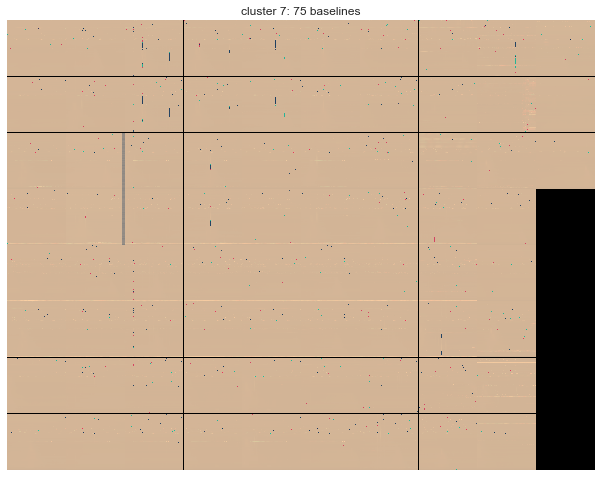

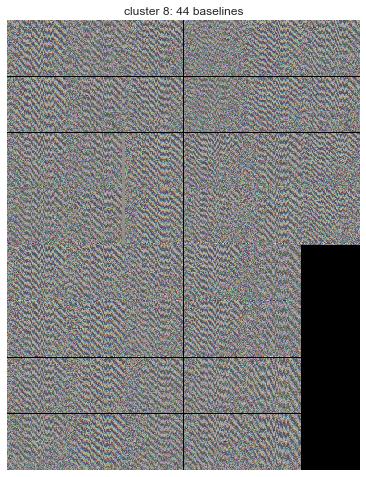

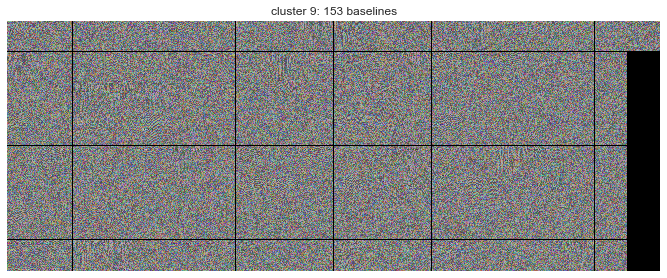

In [11]:
labellist=list(db.labels_)
for cl in range(Kc):
    nclus=labellist.count(cl)
    batch_tensor=torch.zeros(nclus,3,nfreq,ntime)
    idx=[i for i in enumerate(labellist,0) if i[1]==cl]
    ci=0
    for nb,_ in idx:
        vis=get_data_for_baseline_flat(file_name,file_sap,baseline_id=nb,num_channels=num_in_channels)
        batch_tensor[ci]=channel_to_rgb(vis[0])
        ci=ci+1
    grid_img = torchvision.utils.make_grid(batch_tensor,padding=2,normalize=True,scale_each=False)
    plt.figure()
    plt.title('cluster %d: %d baselines'%(cl,nclus))
    plt.axis('off')
    plt.set_cmap('hot')
    plt.imshow(grid_img.permute(2,1,0),aspect='equal')

For a better plot, you can output each spectrogram to a PNG file.